Import

In [28]:
import fasttext 
import pandas as pd 
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string
import math
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

Data

In [101]:
horror = pd.read_csv('horror_movies.csv')

triggers = pd.read_csv('EVERY_trigger_movies.csv')
triggers.fillna(0, inplace = True)

merged = pd.merge(horror, triggers, left_on = 'original_title', right_on = 'Movie')
merged = merged.dropna(subset=['Date'])

merged['Date'] = merged['Date'].astype(int)

In [102]:
print('Number of movies in horror dataset :', len(horror))
print('Number of movies in trigger dataset :', len(triggers))
print('Number of common movies :',len(merged))

Number of movies in horror dataset : 32540
Number of movies in trigger dataset : 49803
Number of common movies : 7878


## Analysis of the whole dataset

In [103]:
#merged = merged[(merged['Date'] != 0) & (merged['Date'] < 2025)]
#merged.drop(['id', 'original_title', 'original_language', 'status', 'adult', 'overview', 'tagline', 'release_date', 'poster_path', 'Type', 'backdrop_path', 'genre_names', 'collection', 'collection_name', 'popularity', 'title', 'vote_average', 'Movie'], axis=1, inplace=True)
#merged = merged.astype(int)

triggers = triggers.apply(lambda col: col.astype(int) if col.dtype in ['float64', 'float32'] else col)
triggers = triggers.replace({1: True, 0: False})

merged = pd.merge(horror, triggers, left_on = 'original_title', right_on = 'Movie')
merged = merged.dropna(subset=['Date'])
merged = merged.replace(0, np.nan)
merged = merged[merged['Date'] > 1960]
trigger_counts = merged.groupby('Date').sum()

/var/folders/tx/k03ny59x1j70p8svzg_91jnh0000gn/T/ipykernel_23914/3157969106.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  triggers = triggers.replace({1: True, 0: False})
/var/folders/tx/k03ny59x1j70p8svzg_91jnh0000gn/T/ipykernel_23914/3157969106.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged = merged.replace(0, np.nan)


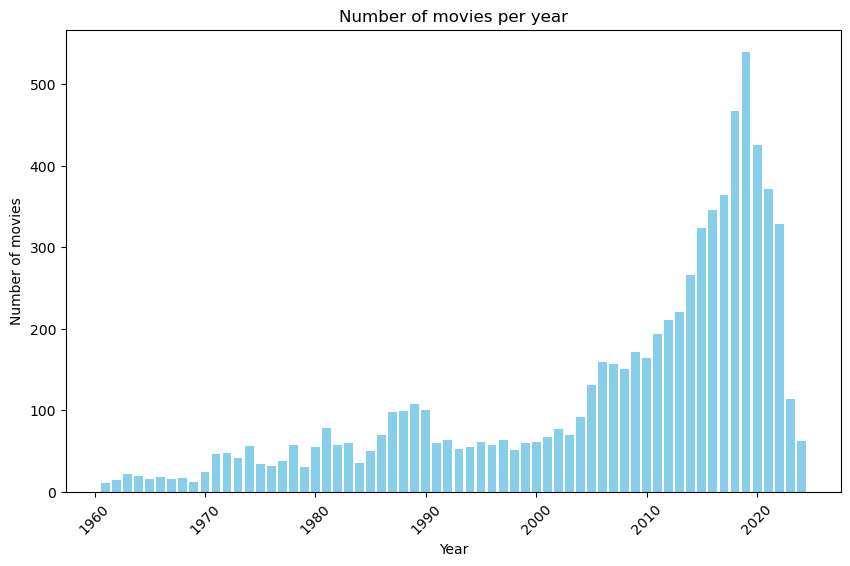

In [105]:
compte = merged.groupby('Date').size().reset_index(name='count')
plt.figure(figsize=(10, 6))
plt.bar(compte['Date'], compte['count'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of movies')
plt.title('Number of movies per year')
plt.xticks(rotation=45)  
plt.show()

## Global analysis of content

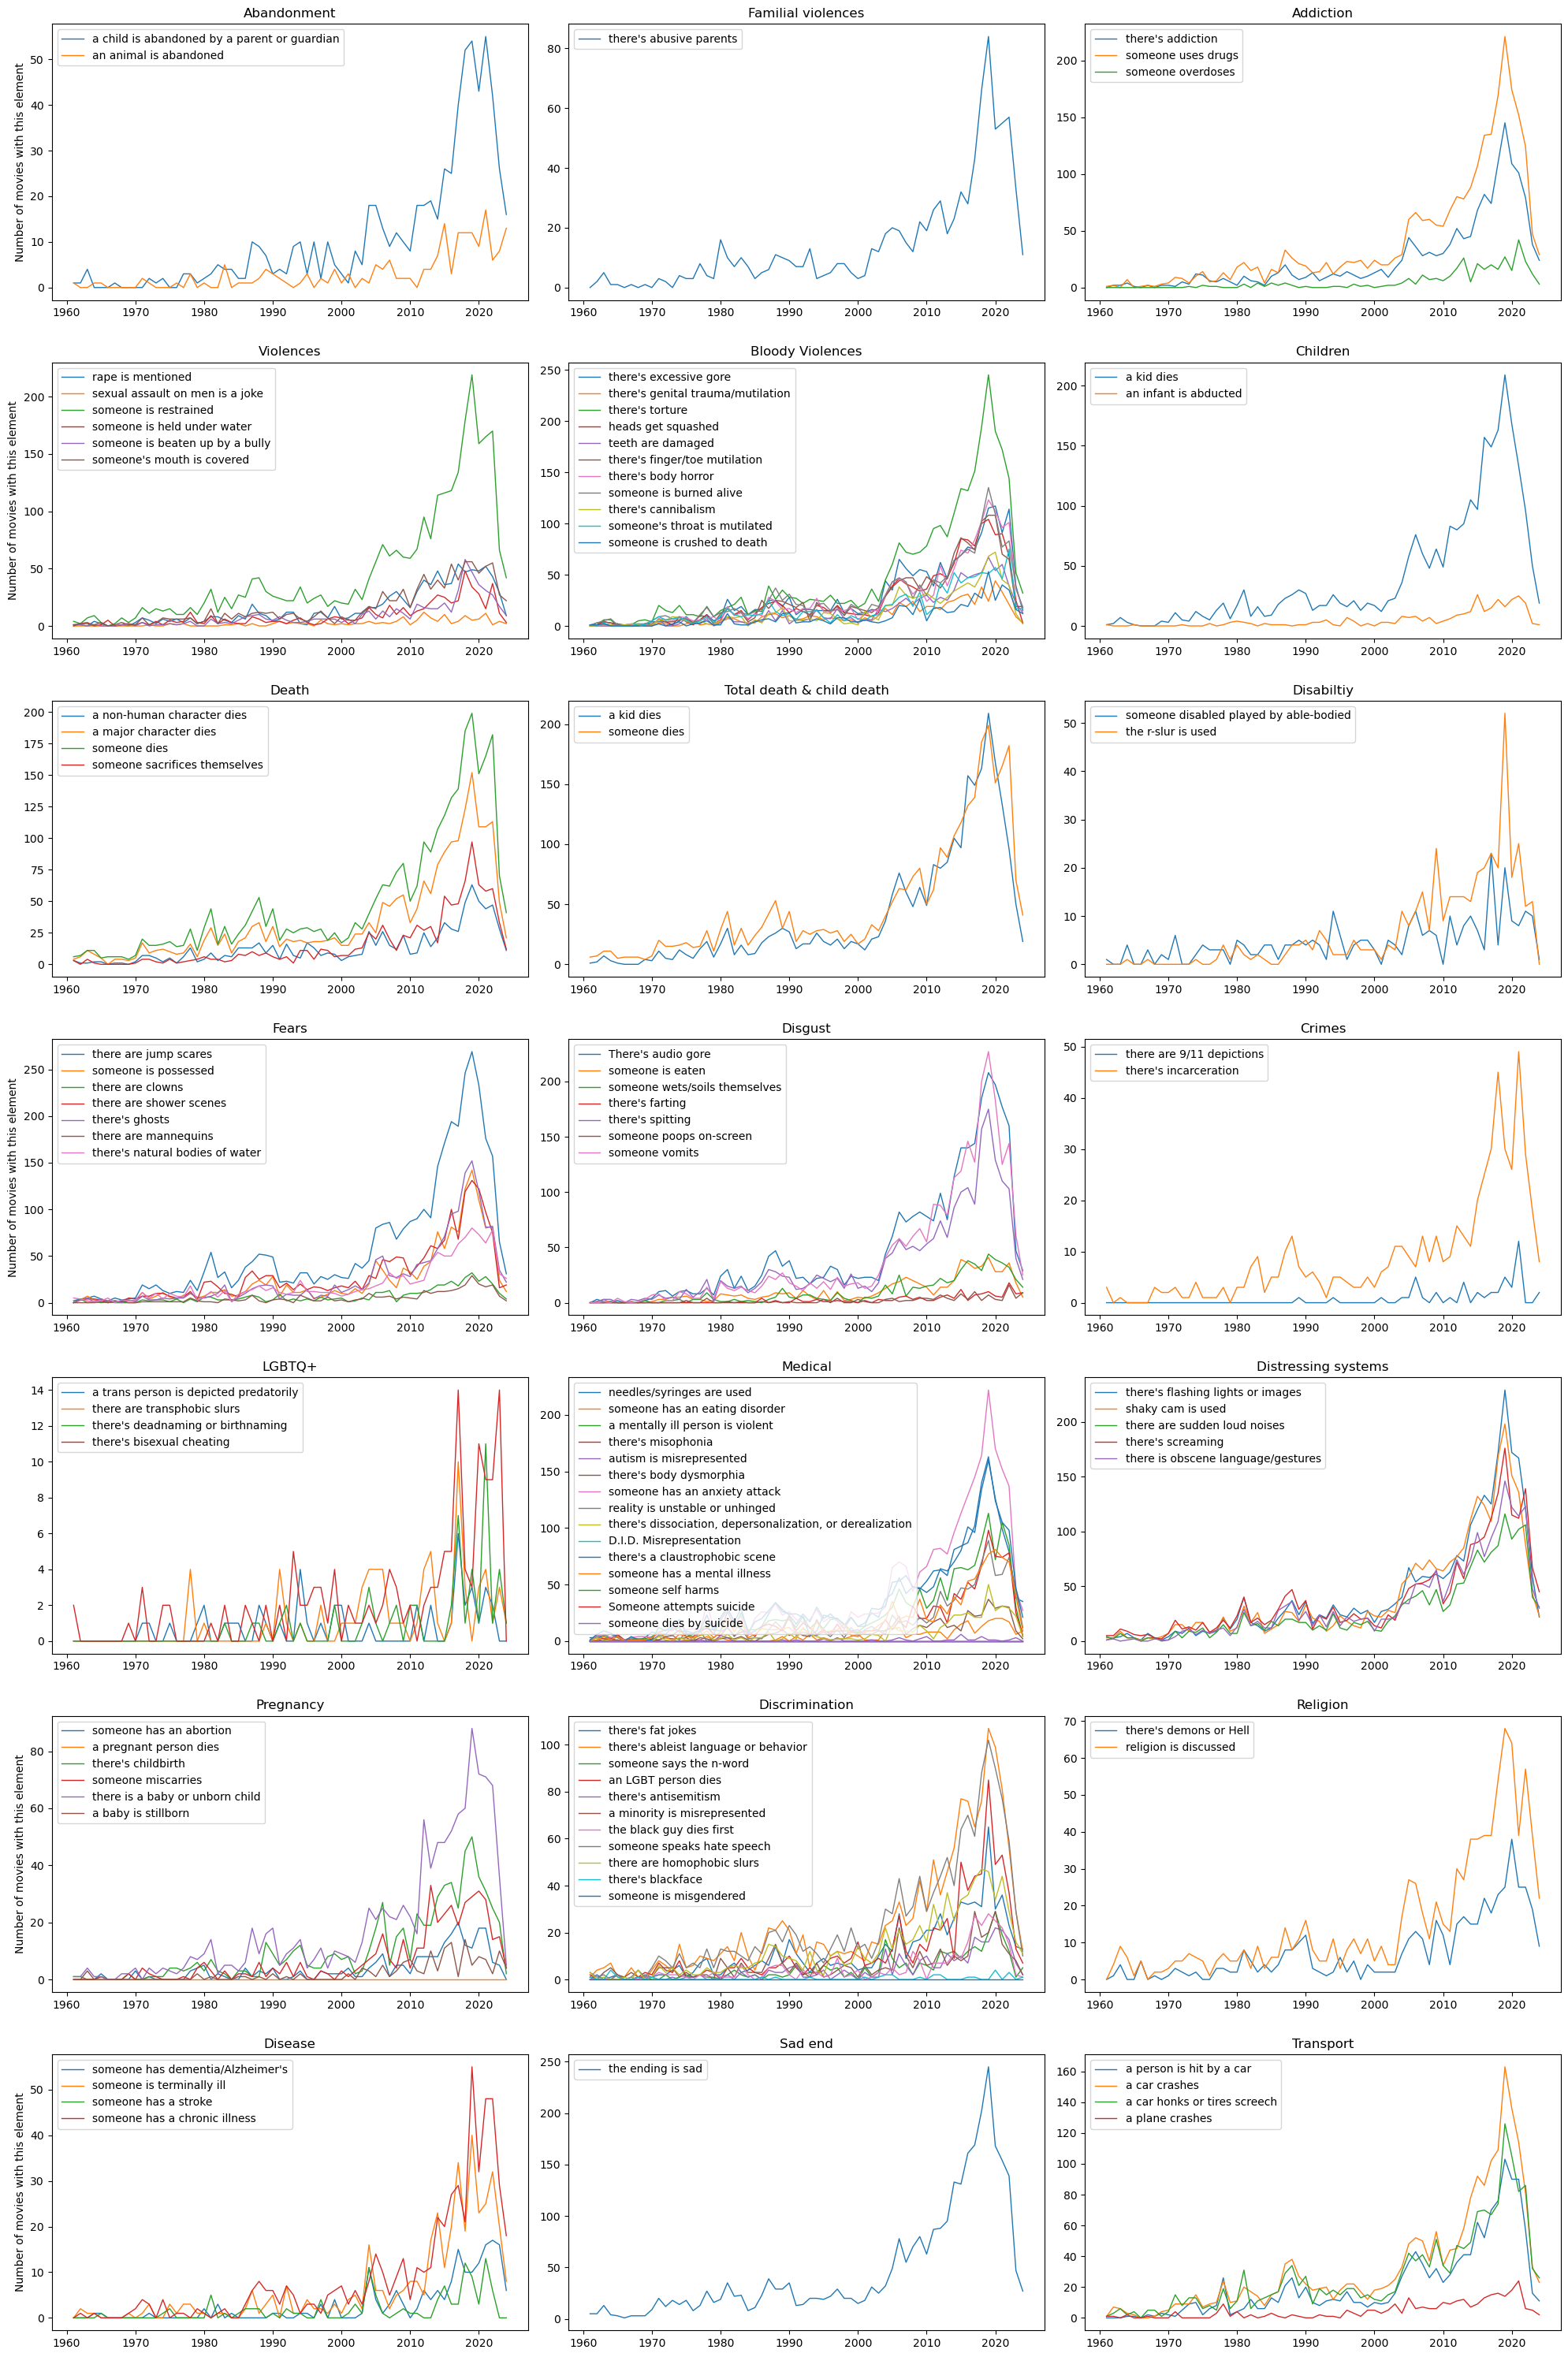

In [106]:
fig, axs = plt.subplots(7, 3, figsize=(20, 30))  

triggers_to_plot1 = ["a child is abandoned by a parent or guardian", "an animal is abandoned"]
for i, trigger in enumerate(triggers_to_plot1):
    axs[0, 0].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1) 
axs[0, 0].set_ylabel("Number of movies with this element")
axs[0, 0].set_title("Abandonment")
axs[0, 0].legend()

triggers_to_plot2 = ["there's abusive parents"]
for i, trigger in enumerate(triggers_to_plot2):
    axs[0, 1].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1) 
axs[0, 1].set_title("Familial violences")
axs[0, 1].legend()

triggers_to_plot3 = ["there's addiction", "someone uses drugs", "someone overdoses"]
for i, trigger in enumerate(triggers_to_plot3):
    axs[0, 2].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1) 
axs[0, 2].set_title("Addiction")
axs[0, 2].legend()

triggers_to_plot4 = ["rape is mentioned", "sexual assault on men is a joke", "someone is restrained", "someone is held under water", "someone is beaten up by a bully", "someone's mouth is covered"]
for i, trigger in enumerate(triggers_to_plot4):
    axs[1, 0].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1) 
axs[1, 0].set_ylabel("Number of movies with this element")
axs[1, 0].set_title("Violences")
axs[1, 0].legend()

triggers_to_plot5 = ["there's excessive gore", "there's genital trauma/mutilation", "there's torture", "heads get squashed", "teeth are damaged", "there's finger/toe mutilation", "there's body horror", "someone is burned alive", "there's cannibalism", "someone's throat is mutilated", "someone is crushed to death"]
for i, trigger in enumerate(triggers_to_plot5):
    axs[1, 1].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1) 
axs[1, 1].set_title("Bloody Violences")
axs[1, 1].legend()

triggers_to_plot6 = ["a kid dies", "an infant is abducted"]
for i, trigger in enumerate(triggers_to_plot6):
    axs[1, 2].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1) 
axs[1, 2].set_title("Children")
axs[1, 2].legend()

triggers_to_plot7 = ["a non-human character dies", "a major character dies", "someone dies", "someone sacrifices themselves"]
for i, trigger in enumerate(triggers_to_plot7):
    axs[2, 0].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1) 
axs[2, 0].set_title("Death")
axs[2, 0].legend()

triggers_to_plot8 = ["a kid dies", "someone dies"]
for i, trigger in enumerate(triggers_to_plot8):
    axs[2, 1].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1) 
axs[2, 1].set_title("Total death & child death")
axs[2, 1].legend()

triggers_to_plot9 = ["someone disabled played by able-bodied", "the r-slur is used"]
for i, trigger in enumerate(triggers_to_plot9):
    axs[2, 2].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1) 
axs[2, 2].set_title("Disabiltiy")
axs[2, 2].legend()

triggers_to_plot10 = ["there are jump scares", "someone is possessed", "there are clowns", "there are shower scenes", "there's ghosts", "there are mannequins", "there's natural bodies of water"]
for i, trigger in enumerate(triggers_to_plot10):
    axs[3, 0].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1) 
axs[3, 0].set_ylabel("Number of movies with this element")
axs[3, 0].set_title("Fears")
axs[3, 0].legend()

triggers_to_plot11 = ["There's audio gore", "someone is eaten", "someone wets/soils themselves", "there's farting", "there's spitting", "someone poops on-screen", "someone vomits"]
for i, trigger in enumerate(triggers_to_plot11):
    axs[3, 1].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1) 
axs[3, 1].set_title("Disgust")
axs[3, 1].legend()

triggers_to_plot12 = ["there are 9/11 depictions", "there's incarceration"]
for i, trigger in enumerate(triggers_to_plot12):
    axs[3, 2].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1) 
axs[3, 2].set_title("Crimes")
axs[3, 2].legend()

colonnes_interval13 = trigger_counts.loc[:, 'a trans person is depicted predatorily': "there's bisexual cheating"]
triggers_to_plot13 = colonnes_interval13.columns.tolist()
for i, trigger in enumerate(triggers_to_plot13):
    axs[4, 0].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1) 
axs[1, 0].set_ylabel("Number of movies with this element")
axs[4, 0].set_title("LGBTQ+")
axs[4, 0].legend()

triggers_to_plot14 = ["needles/syringes are used", "someone has an eating disorder", "a mentally ill person is violent", "there's misophonia", "autism is misrepresented", "there's body dysmorphia", "someone has an anxiety attack", "reality is unstable or unhinged", "there's dissociation, depersonalization, or derealization", "D.I.D. Misrepresentation", "there's a claustrophobic scene", "someone has a mental illness", "someone self harms", "Someone attempts suicide", "someone dies by suicide"]
for i, trigger in enumerate(triggers_to_plot14):
    axs[4, 1].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1) 
axs[4, 1].set_title("Medical")
axs[4, 1].legend()

triggers_to_plot15 = ["there's flashing lights or images", "shaky cam is used", "there are sudden loud noises", "there's screaming", "there is obscene language/gestures"]
for i, trigger in enumerate(triggers_to_plot15):
    axs[4, 2].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1) 
axs[4, 2].set_title("Distressing systems")
axs[4, 2].legend()

triggers_to_plot16 = ["someone has an abortion", "a pregnant person dies", "there's childbirth", "someone miscarries", "there is a baby or unborn child", "a baby is stillborn"]
for i, trigger in enumerate(triggers_to_plot16):
    axs[5, 0].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1) 
axs[5, 0].set_ylabel("Number of movies with this element")
axs[5, 0].set_title("Pregnancy")
axs[5, 0].legend()

triggers_to_plot17 = ["there's fat jokes", "there's ableist language or behavior", "someone says the n-word", "an LGBT person dies", "there's antisemitism", "a minority is misrepresented", "the black guy dies first", "someone speaks hate speech", "there are homophobic slurs", "there's blackface","someone is misgendered"]
for i, trigger in enumerate(triggers_to_plot17):
    axs[5, 1].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1) 
axs[5, 1].set_title("Discrimination")
axs[5, 1].legend()

triggers_to_plot18 = ["there's demons or Hell", "religion is discussed"]
for i, trigger in enumerate(triggers_to_plot18):
    axs[5, 2].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1) 
axs[5, 2].set_title("Religion")
axs[5, 2].legend()

triggers_to_plot19 = ["someone has dementia/Alzheimer's", "someone is terminally ill", "someone has a stroke", "someone has a chronic illness"]
for i, trigger in enumerate(triggers_to_plot19):
    axs[6, 0].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1) 
axs[6, 0].set_ylabel("Number of movies with this element")
axs[6, 0].set_title("Disease")
axs[6, 0].legend()

triggers_to_plot20 = ["the ending is sad"]
for i, trigger in enumerate(triggers_to_plot20):
    axs[6, 1].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1) 
axs[6, 1].set_title("Sad end")
axs[6, 1].legend()

triggers_to_plot21 = ["a person is hit by a car", "a car crashes", "a car honks or tires screech", "a plane crashes"]
for i, trigger in enumerate(triggers_to_plot21):
    axs[6, 2].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1) 
axs[6, 2].set_title("Transport")
axs[6, 2].legend()

plt.tight_layout()
plt.show()

### Standardized 

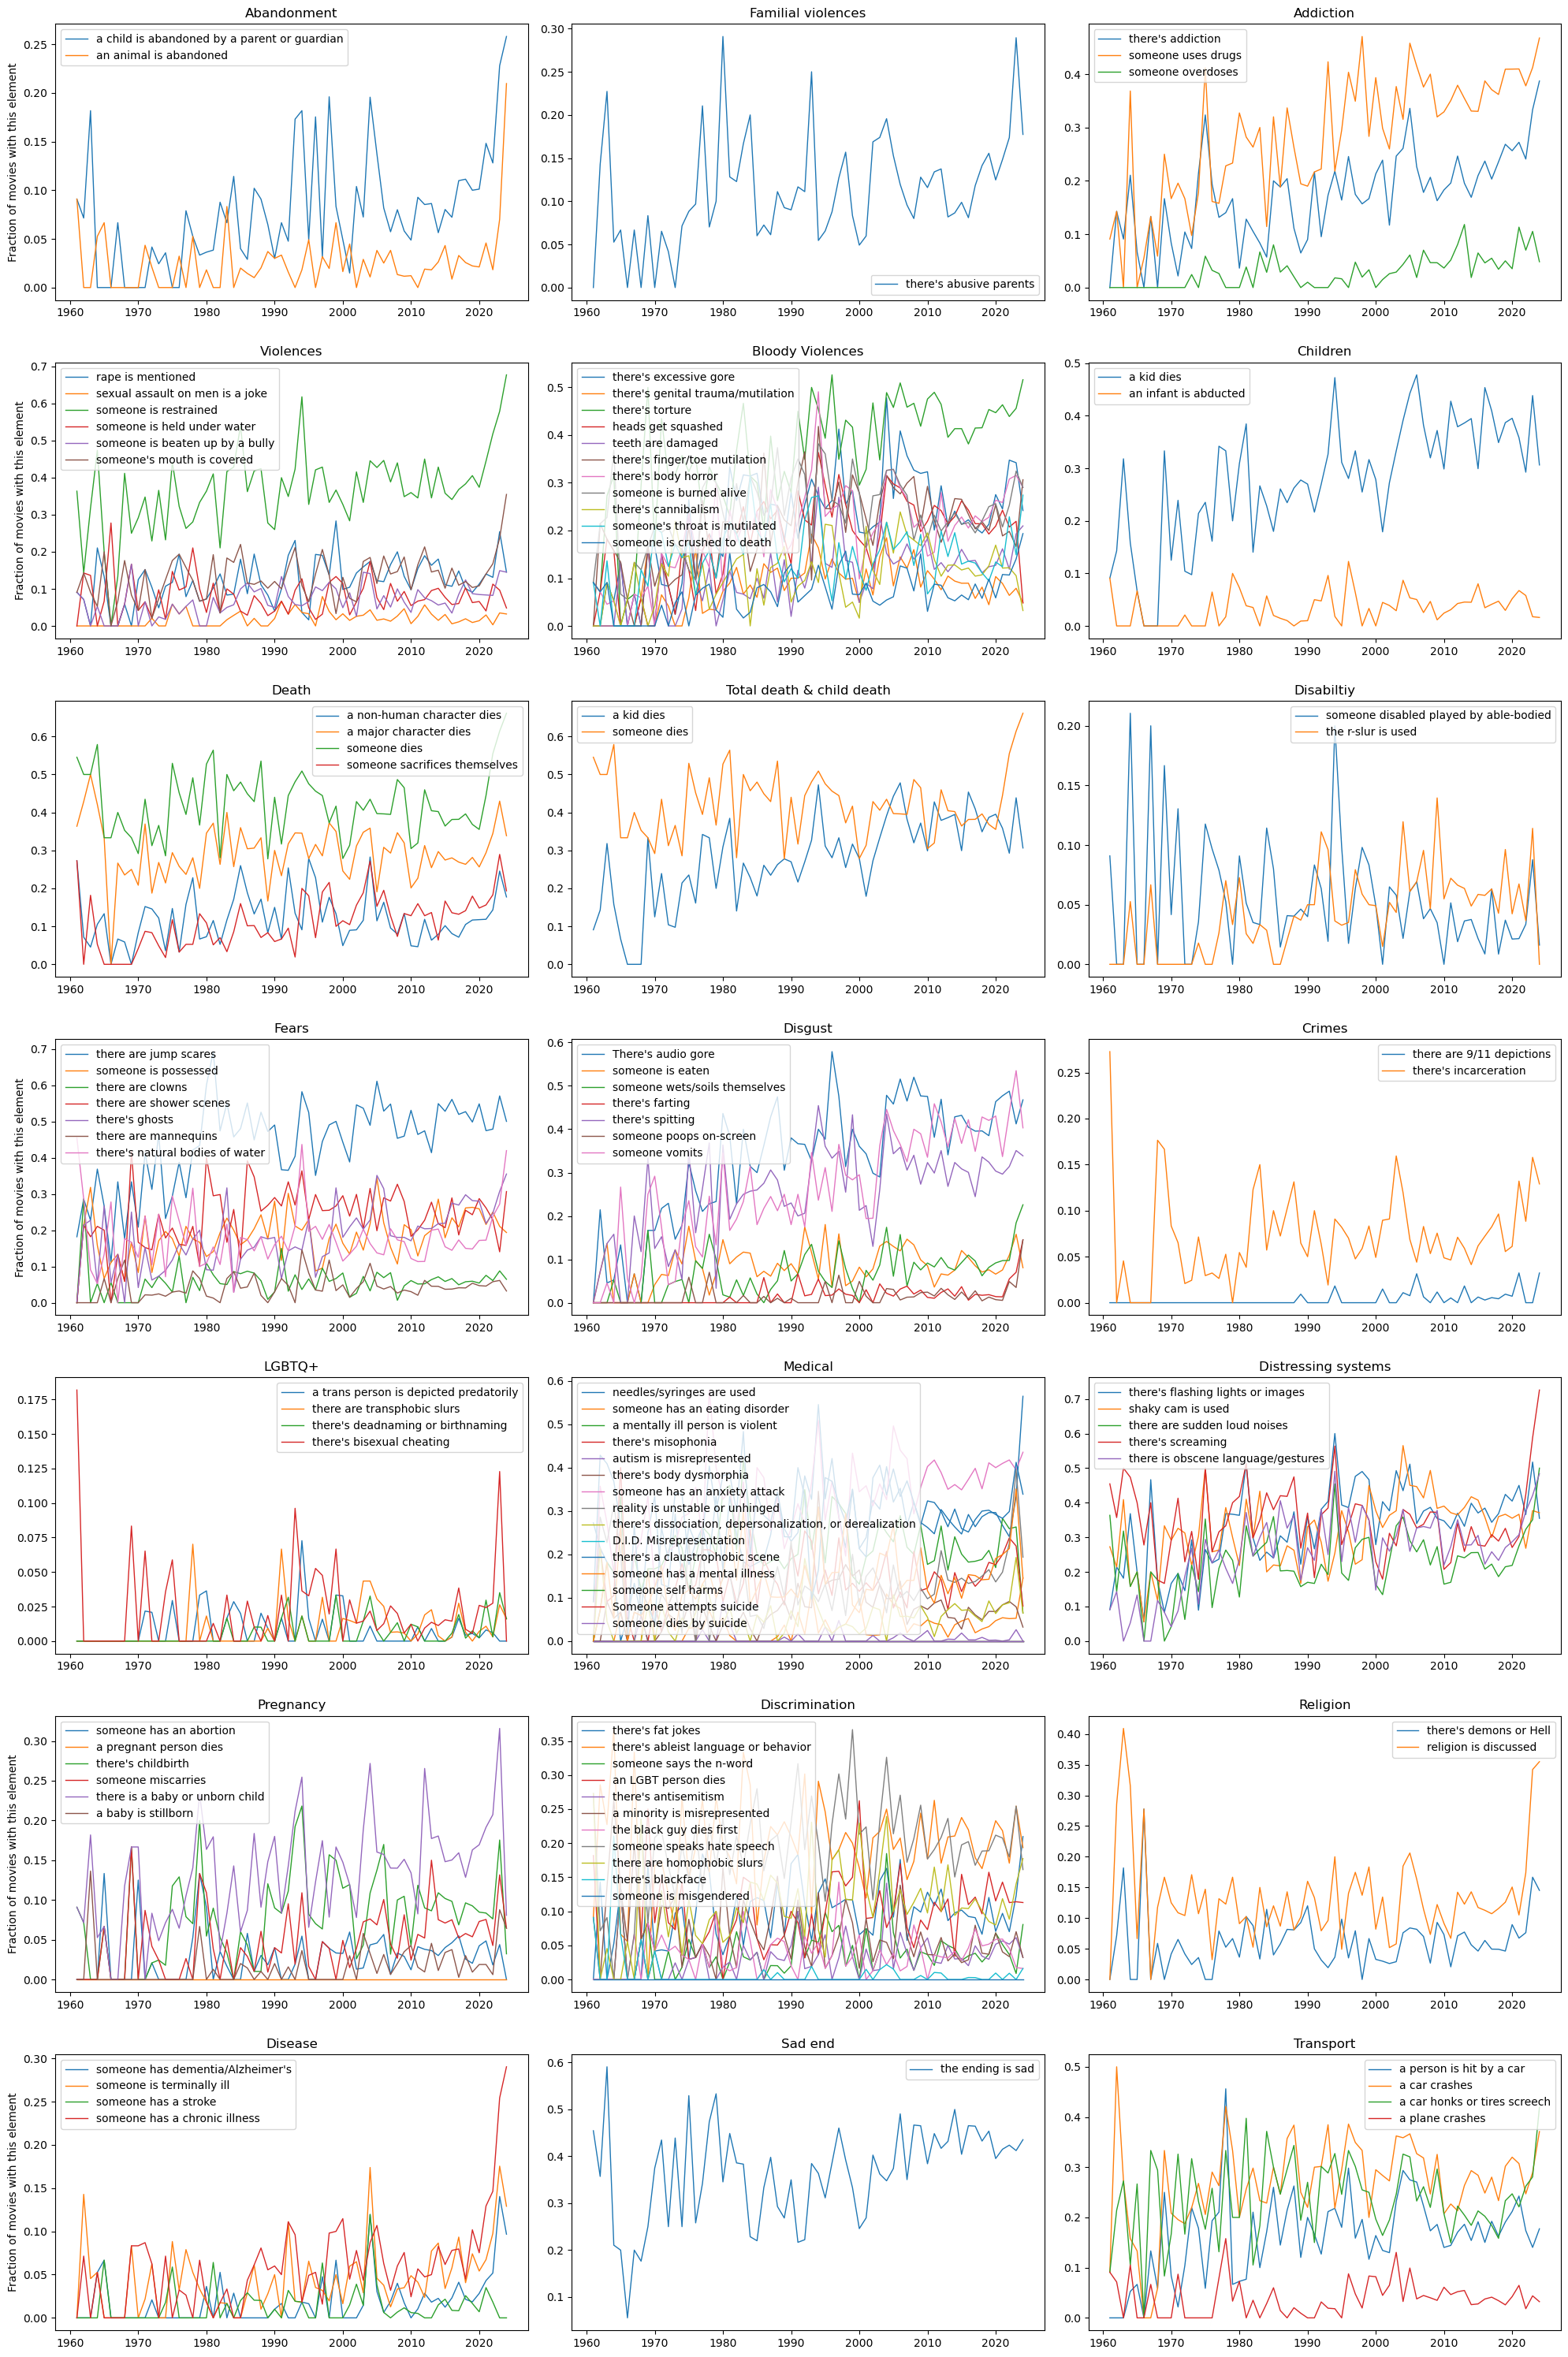

In [107]:
fig, axs = plt.subplots(7, 3, figsize=(20, 30))  

triggers_to_plot1 = ["a child is abandoned by a parent or guardian", "an animal is abandoned"]
for i, trigger in enumerate(triggers_to_plot1):
    axs[0, 0].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1) 
axs[0, 0].set_ylabel("Fraction of movies with this element")
axs[0, 0].set_title("Abandonment")
axs[0, 0].legend()

triggers_to_plot2 = ["there's abusive parents"]
for i, trigger in enumerate(triggers_to_plot2):
    axs[0, 1].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1) 
axs[0, 1].set_title("Familial violences")
axs[0, 1].legend()

triggers_to_plot3 = ["there's addiction", "someone uses drugs", "someone overdoses"]
for i, trigger in enumerate(triggers_to_plot3):
    axs[0, 2].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1) 
axs[0, 2].set_title("Addiction")
axs[0, 2].legend()

triggers_to_plot4 = ["rape is mentioned", "sexual assault on men is a joke", "someone is restrained", "someone is held under water", "someone is beaten up by a bully", "someone's mouth is covered"]
for i, trigger in enumerate(triggers_to_plot4):
    axs[1, 0].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1) 
axs[1, 0].set_ylabel("Fraction of movies with this element")
axs[1, 0].set_title("Violences")
axs[1, 0].legend()

triggers_to_plot5 = ["there's excessive gore", "there's genital trauma/mutilation", "there's torture", "heads get squashed", "teeth are damaged", "there's finger/toe mutilation", "there's body horror", "someone is burned alive", "there's cannibalism", "someone's throat is mutilated", "someone is crushed to death"]
for i, trigger in enumerate(triggers_to_plot5):
    axs[1, 1].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1) 
axs[1, 1].set_title("Bloody Violences")
axs[1, 1].legend()

triggers_to_plot6 = ["a kid dies", "an infant is abducted"]
for i, trigger in enumerate(triggers_to_plot6):
    axs[1, 2].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1) 
axs[1, 2].set_title("Children")
axs[1, 2].legend()

triggers_to_plot7 = ["a non-human character dies", "a major character dies", "someone dies", "someone sacrifices themselves"]
for i, trigger in enumerate(triggers_to_plot7):
    axs[2, 0].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1) 
axs[2, 0].set_title("Death")
axs[2, 0].legend()

triggers_to_plot8 = ["a kid dies", "someone dies"]
for i, trigger in enumerate(triggers_to_plot8):
    axs[2, 1].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1) 
axs[2, 1].set_title("Total death & child death")
axs[2, 1].legend()

triggers_to_plot9 = ["someone disabled played by able-bodied", "the r-slur is used"]
for i, trigger in enumerate(triggers_to_plot9):
    axs[2, 2].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1) 
axs[2, 2].set_title("Disabiltiy")
axs[2, 2].legend()

triggers_to_plot10 = ["there are jump scares", "someone is possessed", "there are clowns", "there are shower scenes", "there's ghosts", "there are mannequins", "there's natural bodies of water"]
for i, trigger in enumerate(triggers_to_plot10):
    axs[3, 0].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1) 
axs[3, 0].set_ylabel("Fraction of movies with this element")
axs[3, 0].set_title("Fears")
axs[3, 0].legend()

triggers_to_plot11 = ["There's audio gore", "someone is eaten", "someone wets/soils themselves", "there's farting", "there's spitting", "someone poops on-screen", "someone vomits"]
for i, trigger in enumerate(triggers_to_plot11):
    axs[3, 1].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1) 
axs[3, 1].set_title("Disgust")
axs[3, 1].legend()

triggers_to_plot12 = ["there are 9/11 depictions", "there's incarceration"]
for i, trigger in enumerate(triggers_to_plot12):
    axs[3, 2].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1) 
axs[3, 2].set_title("Crimes")
axs[3, 2].legend()

colonnes_interval13 = trigger_counts.loc[:, 'a trans person is depicted predatorily': "there's bisexual cheating"]
triggers_to_plot13 = colonnes_interval13.columns.tolist()
for i, trigger in enumerate(triggers_to_plot13):
    axs[4, 0].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1) 
axs[1, 0].set_ylabel("Fraction of movies with this element")
axs[4, 0].set_title("LGBTQ+")
axs[4, 0].legend()

triggers_to_plot14 = ["needles/syringes are used", "someone has an eating disorder", "a mentally ill person is violent", "there's misophonia", "autism is misrepresented", "there's body dysmorphia", "someone has an anxiety attack", "reality is unstable or unhinged", "there's dissociation, depersonalization, or derealization", "D.I.D. Misrepresentation", "there's a claustrophobic scene", "someone has a mental illness", "someone self harms", "Someone attempts suicide", "someone dies by suicide"]
for i, trigger in enumerate(triggers_to_plot14):
    axs[4, 1].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1) 
axs[4, 1].set_title("Medical")
axs[4, 1].legend()

triggers_to_plot15 = ["there's flashing lights or images", "shaky cam is used", "there are sudden loud noises", "there's screaming", "there is obscene language/gestures"]
for i, trigger in enumerate(triggers_to_plot15):
    axs[4, 2].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1) 
axs[4, 2].set_title("Distressing systems")
axs[4, 2].legend()

triggers_to_plot16 = ["someone has an abortion", "a pregnant person dies", "there's childbirth", "someone miscarries", "there is a baby or unborn child", "a baby is stillborn"]
for i, trigger in enumerate(triggers_to_plot16):
    axs[5, 0].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1) 
axs[5, 0].set_ylabel("Fraction of movies with this element")
axs[5, 0].set_title("Pregnancy")
axs[5, 0].legend()

triggers_to_plot17 = ["there's fat jokes", "there's ableist language or behavior", "someone says the n-word", "an LGBT person dies", "there's antisemitism", "a minority is misrepresented", "the black guy dies first", "someone speaks hate speech", "there are homophobic slurs", "there's blackface","someone is misgendered"]
for i, trigger in enumerate(triggers_to_plot17):
    axs[5, 1].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1) 
axs[5, 1].set_title("Discrimination")
axs[5, 1].legend()

triggers_to_plot18 = ["there's demons or Hell", "religion is discussed"]
for i, trigger in enumerate(triggers_to_plot18):
    axs[5, 2].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1) 
axs[5, 2].set_title("Religion")
axs[5, 2].legend()

triggers_to_plot19 = ["someone has dementia/Alzheimer's", "someone is terminally ill", "someone has a stroke", "someone has a chronic illness"]
for i, trigger in enumerate(triggers_to_plot19):
    axs[6, 0].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1) 
axs[6, 0].set_ylabel("Fraction of movies with this element")
axs[6, 0].set_title("Disease")
axs[6, 0].legend()

triggers_to_plot20 = ["the ending is sad"]
for i, trigger in enumerate(triggers_to_plot20):
    axs[6, 1].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1) 
axs[6, 1].set_title("Sad end")
axs[6, 1].legend()

triggers_to_plot21 = ["a person is hit by a car", "a car crashes", "a car honks or tires screech", "a plane crashes"]
for i, trigger in enumerate(triggers_to_plot21):
    axs[6, 2].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1) 
axs[6, 2].set_title("Transport")
axs[6, 2].legend()

plt.tight_layout()
plt.show()

### Study of the correlation for some of the features

In [116]:
df_boolean = merged.select_dtypes(include=[bool]).astype(int)
df_boolean

adult  a dog dies  animals are abused  an animal dies  a cat dies  \
0         0           0                   0               1           0   
1         0           0                   1               1           1   
2         0           0                   1               1           1   
3         0           0                   0               0           0   
4         0           0                   0               1           0   
...     ...         ...                 ...             ...         ...   
7873      0           0                   0               1           0   
7874      0           0                   0               0           0   
7875      0           0                   0               0           0   
7876      0           0                   1               1           0   
7877      0           0                   0               1           0   

      a pet dies  animals were harmed in the making  there's dog fighting  \
0              1                                  0                     0   
1              0                                  0                     0   
2              1                                  0                     0   
3              0                                  0                     0   
4              0                                  0                     0   
...          ...                                ...                   ...   
7873           0                                  0                     0   
7874           0                                  0                     0   
7875           0                                  0                     0   
7876           1                                  0                     0   
7877           0                                  0                     0   

      there's a dead animal  a horse dies  ...  there's end credits scenes?  \
0                         1             0  ...                            0   
1                         1             0  ...                            0   
2                         1             0  ...                            0   
3                         1             0  ...                            0   
4                         1             0  ...                            0   
...                     ...           ...  ...                          ...   
7873                      0             0  ...                            0   
7874                      0             0  ...                            0   
7875                      0             0  ...                            0   
7876                      1             1  ...                            0   
7877                      0             0  ...                            1   

      Santa (et al) is spoiled  a person is hit by a car  a car crashes  \
0                            0                         0              0   
1                            0                         0              1   
2                            1                         1              1   
3                            0                         1              0   
4                            0                         0              0   
...                        ...                       ...            ...   
7873                         0                         0              0   
7874                         0                         0              0   
7875                         0                         0              0   
7876                         0                         0              0   
7877                         0                         0              0   

      a car honks or tires screech  a plane crashes  there's gun violence  \
0                                0                0                     1   
1                                1                0                     1   
2                                1                0                     1   
3                     

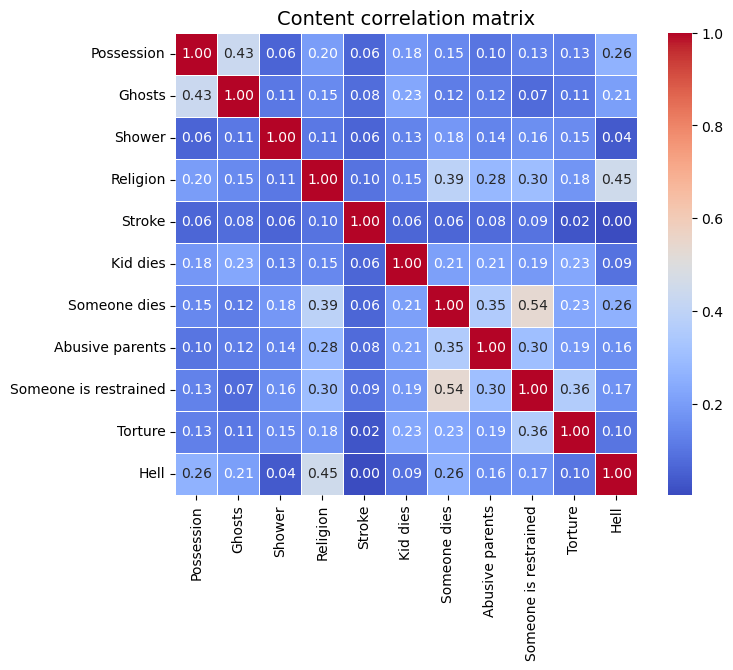

In [115]:
df = pd.DataFrame({
    'Possession': merged["someone is possessed"],
    'Ghosts':merged["there's ghosts"] ,
    'Shower': merged["there are shower scenes"] ,
    'Religion': merged['religion is discussed'],
    'Stroke': merged['someone has a stroke'],
    'Kid dies': merged['a kid dies'] ,
    'Someone dies': merged['someone dies'],
    'Abusive parents': merged["there's abusive parents"],
    'Someone is restrained': merged["someone is restrained"],
    'Torture': merged["there's torture"] ,
    'Hell': merged["there's demons or Hell"] 
    })

correlation_matrix = df.corr()

plt.figure(figsize=(8, 6))  # Taille de la figure
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            cbar=True, square=True, linewidths=0.5, annot_kws={"size": 10})
plt.title("Content correlation matrix", fontsize=14)
plt.xticks(rotation=90)  # Rotation des labels des axes x
plt.yticks(rotation=0)   # Rotation des labels des axes y
plt.show()


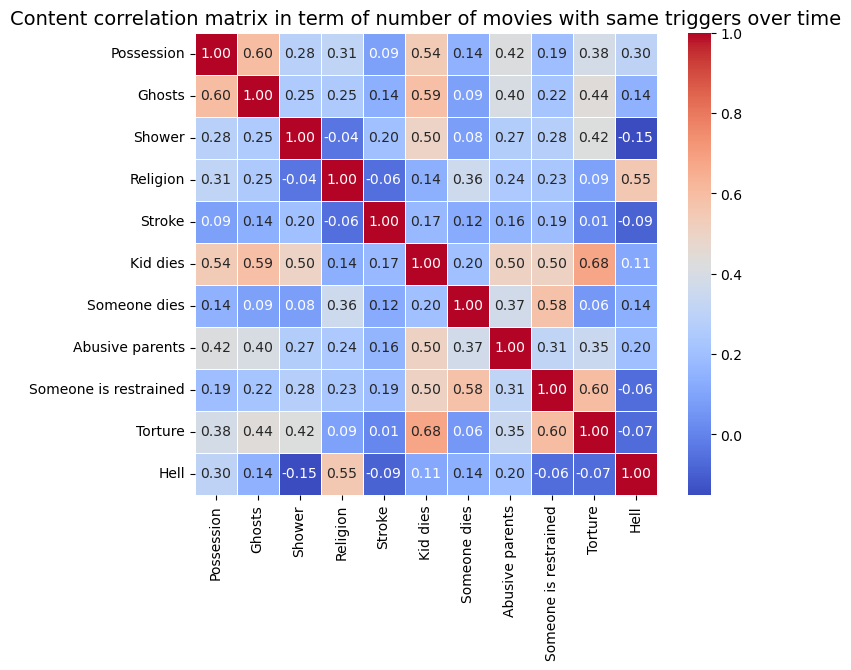

In [114]:
df = pd.DataFrame({
    'Possession': trigger_counts["someone is possessed"].values / compte['count'],
    'Ghosts': trigger_counts["there's ghosts"].values / compte['count'],
    'Shower': trigger_counts["there are shower scenes"].values / compte['count'],
    'Religion': trigger_counts['religion is discussed'].values / compte['count'],
    'Stroke': trigger_counts['someone has a stroke'].values / compte['count'],
    'Kid dies': trigger_counts['a kid dies'].values / compte['count'],
    'Someone dies': trigger_counts['someone dies'].values / compte['count'],
    'Abusive parents': trigger_counts["there's abusive parents"].values / compte['count'],
    'Someone is restrained': trigger_counts["someone is restrained"].values / compte['count'],
    'Torture': trigger_counts["there's torture"].values / compte['count'],
    'Hell': trigger_counts["there's demons or Hell"].values / compte['count']
    })

correlation_matrix = df.corr()

plt.figure(figsize=(8, 6))  # Taille de la figure
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            cbar=True, square=True, linewidths=0.5, annot_kws={"size": 10})
plt.title("Content correlation matrix in term of number of movies with same triggers over time", fontsize=14)
plt.xticks(rotation=90)  # Rotation des labels des axes x
plt.yticks(rotation=0)   # Rotation des labels des axes y
plt.show()


## Analysis of content repartition

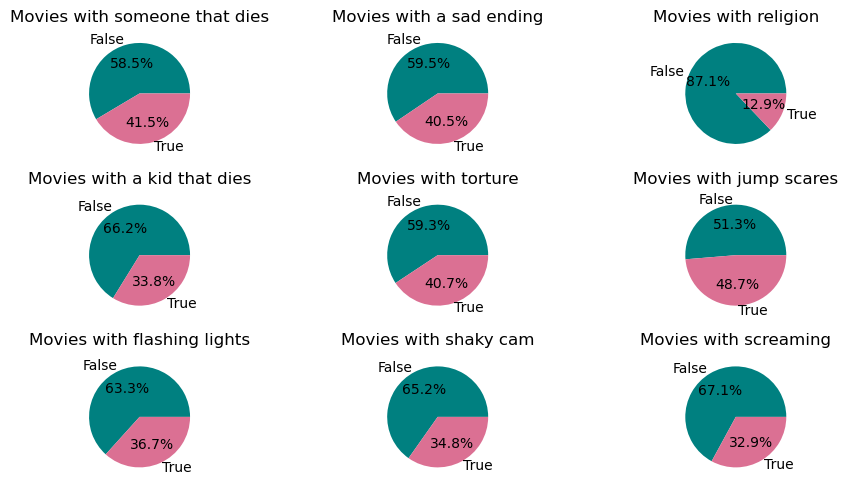

In [20]:
colors = [ 'teal', 'palevioletred']

fix, axs = plt.subplots(3,3, figsize = (10,5))

merged['someone dies'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors = colors, ax = axs[0, 0], ylabel = '')
axs[0,0].set_title('Movies with someone that dies')

merged['the ending is sad'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors = colors, ax = axs[0,1], ylabel = '')
axs[0,1].set_title('Movies with a sad ending')

merged['religion is discussed'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors = colors, ax = axs[0,2], ylabel = '')
axs[0,2].set_title('Movies with religion')

merged['a kid dies'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors = colors, ax = axs[1,0], ylabel = '')
axs[1,0].set_title('Movies with a kid that dies')

merged["there's torture"].value_counts().plot(kind='pie', autopct='%1.1f%%', colors = colors, ax = axs[1,1], ylabel = '')
axs[1,1].set_title('Movies with torture')

merged["there are jump scares"].value_counts().plot(kind='pie', autopct='%1.1f%%', colors = colors, ax = axs[1,2], ylabel = '')
axs[1,2].set_title('Movies with jump scares')

merged["there's flashing lights or images"].value_counts().plot(kind='pie', autopct='%1.1f%%', colors = colors, ax = axs[2,0], ylabel = '')
axs[2,0].set_title('Movies with flashing lights')

merged["shaky cam is used"].value_counts().plot(kind='pie', autopct='%1.1f%%', colors = colors, ax = axs[2,1], ylabel = '')
axs[2,1].set_title('Movies with shaky cam')

merged["there's screaming"].value_counts().plot(kind='pie', autopct='%1.1f%%', colors = colors, ax = axs[2,2], ylabel = '')
axs[2,2].set_title('Movies with screaming')

plt.tight_layout()
plt.show()
